## Test EDA

In [62]:
# Load libraries
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from xgboost.callback import TrainingCallback

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt


In [63]:
# Load datasets
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Backup test IDs for later use in submission
test_ids = test_df["id"].copy()

# Drop ID columns
train_df.drop(columns=["id"], inplace=True)
test_df.drop(columns=["id"], inplace=True)


In [64]:
# Head data
train_df.head()


,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,37,70,36,Clayey,Sugarcane,36,4,5,28-28
1,27,69,65,Sandy,Millets,30,6,18,28-28
2,29,63,32,Sandy,Millets,24,12,16,17-17-17
3,35,62,54,Sandy,Barley,39,12,4,10-26-26
4,35,58,43,Red,Paddy,37,2,16,DAP


In [65]:
# Head data
test_df.head()


,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous
0,31,70,52,Sandy,Wheat,34,11,24
1,27,62,45,Red,Sugarcane,30,14,15
2,28,72,28,Clayey,Ground Nuts,14,15,4
3,37,53,57,Black,Ground Nuts,18,17,36
4,31,55,32,Red,Pulses,13,19,14


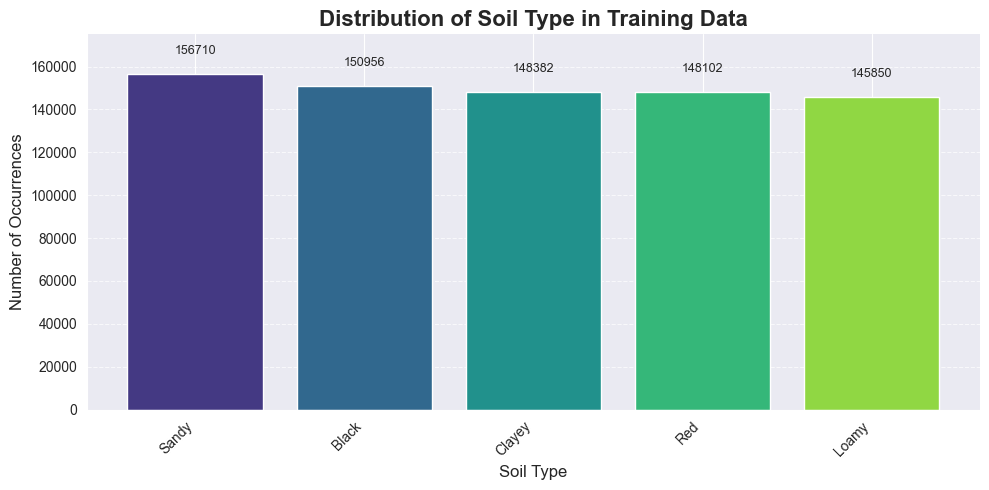

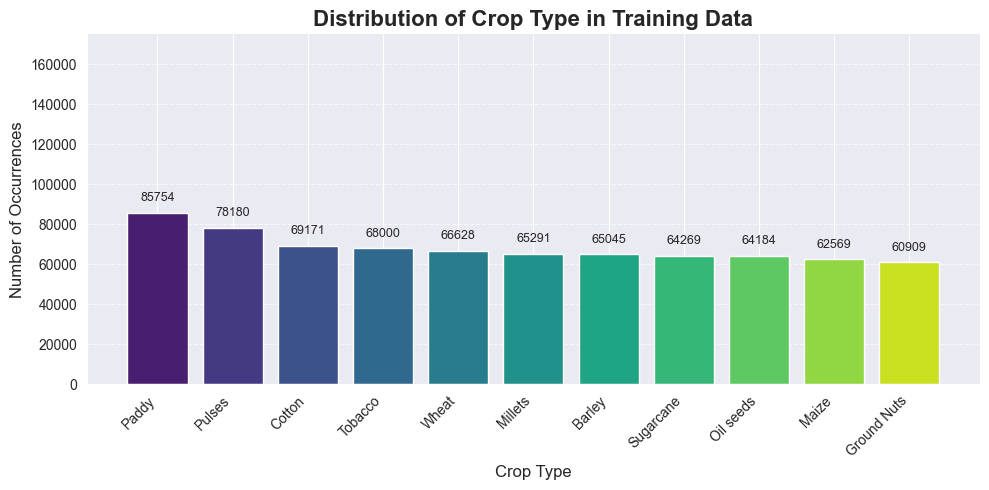

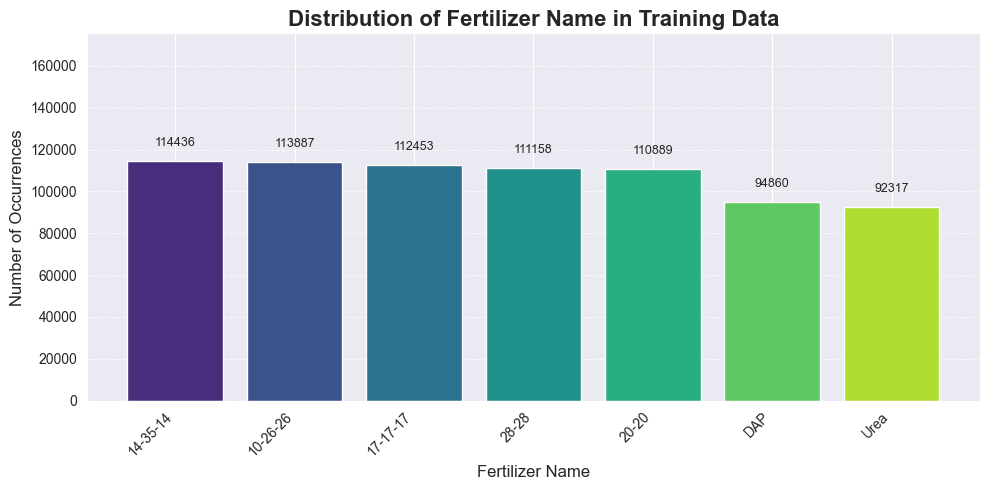

In [66]:
# Columns to plot
categorical_columns = ["Soil Type", "Crop Type", "Fertilizer Name"]

for col in categorical_columns:
    value_counts = train_df[col].value_counts()
    
    fig, ax = plt.subplots(figsize=(10, 5))
    colors = sns.color_palette('viridis', len(value_counts))

    bars = ax.bar(value_counts.index, value_counts.values, color=colors)

    # Add value labels
    for i, bar in enumerate(bars):
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.05 * value_counts.max(),
                f'{int(yval)}', ha='center', va='bottom', fontsize=9)

    # Plot formatting
    ax.set_title(f'Distribution of {col} in Training Data', fontsize=16, fontweight='bold')
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel('Number of Occurrences', fontsize=12)
    ax.set_ylim(top=175000)
    ax.set_xticks(range(len(value_counts)))
    ax.set_xticklabels(value_counts.index, rotation=45, ha='right', fontsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    sns.despine(ax=ax)

    plt.tight_layout()
    plt.show()
    

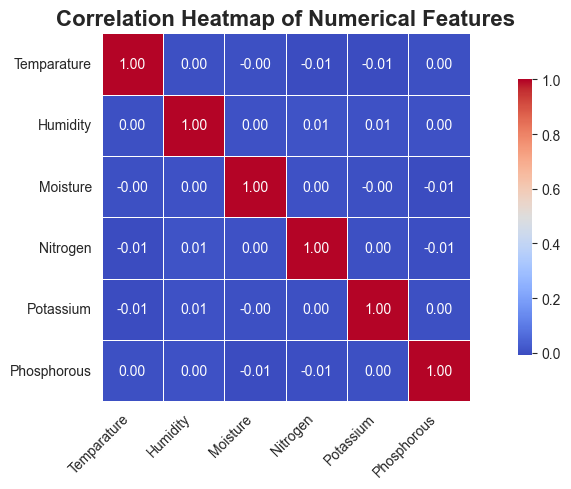

In [67]:
# Plot heatmap
num_columns = ["Temparature", "Humidity", "Moisture", "Nitrogen", "Potassium", "Phosphorous"]
corr_matrix = train_df[num_columns].corr()

# Create heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True,
            linewidths=0.5, cbar_kws={"shrink": 0.75})

plt.title('Correlation Heatmap of Numerical Features', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [68]:
# Function to detect outliers using IQR
def detect_outliers_iqr(df):
    outlier_info = {}
    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_info[col] = {
            'outlier_count': len(outliers),
            'outlier_indices': outliers.index.tolist()
        }
    return outlier_info

# Run the function and print the outlier summary
outliers = detect_outliers_iqr(train_df)

for col, info in outliers.items():
    print(f"{col}: {info['outlier_count']} outliers")


Temparature: 0 outliers
Humidity: 0 outliers
Moisture: 0 outliers
Nitrogen: 0 outliers
Potassium: 0 outliers
Phosphorous: 0 outliers


In [69]:
# Configuration
class Config:
    state = 42
    early_stop = 100
    nclass = 7  # number of unique fertilizer labels
    n_estimators = 3000
    learning_rate = 0.1
    max_depth = 20
    reg_lambda = 0.05656209749983576
    reg_alpha = 5.620898657099113
    colsample_bytree = 0.2587327850345624
    subsample = 0.8276149323901826
    min_child_weight = 10
    booster = "gbtree"
    device = "cuda"
    tree_method = "hist"
    objective = "multi:softprob"
    eval_metric = "mlogloss"
    verbosity = 0
    enable_categorical = True
    n_jobs = -1


In [70]:
# tqdm callback for training progress
class TQDMCallback(TrainingCallback):
    def __init__(self, total_rounds):
        super().__init__()  # Proper superclass initialization
        self.pbar = tqdm(total=total_rounds, desc="Training Progress", dynamic_ncols=True, leave=True)

    def after_iteration(self, model, epoch, evals_log):
        self.pbar.update(1)
        return False

    def after_training(self, model):
        self.pbar.close()
        return model


In [71]:
# Encode categorical features
cat_cols = ["Soil Type", "Crop Type"]
ordinal_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
train_df[cat_cols] = ordinal_encoder.fit_transform(train_df[cat_cols].astype(str))
test_df[cat_cols] = ordinal_encoder.transform(test_df[cat_cols].astype(str))

# Keep original string target labels
y = train_df["Fertilizer Name"]
X = train_df.drop(columns=["Fertilizer Name"])

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=Config.state)

# Prepare class name mapping
class_names = sorted(y.unique())
class_to_index = {cls: idx for idx, cls in enumerate(class_names)}
index_to_class = {idx: cls for cls, idx in class_to_index.items()}

# Convert y to indices for training
y_train_idx = y_train.map(class_to_index)
y_val_idx = y_val.map(class_to_index)

In [72]:
# Train model
progress_bar = TQDMCallback(total_rounds=Config.n_estimators)
model = XGBClassifier(
    tree_method=Config.tree_method,
    n_estimators=Config.n_estimators,
    objective=Config.objective,
    random_state=Config.state,
    enable_categorical=Config.enable_categorical,
    verbosity=Config.verbosity,
    early_stopping_rounds=Config.early_stop,
    eval_metric=Config.eval_metric,
    booster=Config.booster,
    device=Config.device,
    n_jobs=Config.n_jobs,
    learning_rate=Config.learning_rate,
    num_class=Config.nclass,
    reg_lambda=Config.reg_lambda,
    reg_alpha=Config.reg_alpha,
    colsample_bytree=Config.colsample_bytree,
    subsample=Config.subsample,
    max_depth=Config.max_depth,
    min_child_weight=Config.min_child_weight,
    callbacks=[progress_bar]
)
model.fit(X_train, y_train_idx, eval_set=[(X_val, y_val_idx)], verbose=False)


Training Progress:  22%|██▏       | 646/3000 [01:01<03:44, 10.48it/s]


XGBClassifier(base_score=None, booster='gbtree',
              callbacks=[<__main__.TQDMCallback object at 0x00000232D5E41550>],
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.2587327850345624, device='cuda',
              early_stopping_rounds=100, enable_categorical=True,
              eval_metric='mlogloss', feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=3000, n_jobs=-1, num_class=7, ...)

In [73]:
# Validation prediction for MAP@3
val_probs = model.predict_proba(X_val)
top_3_preds = np.argsort(val_probs, axis=1)[:, -3:][:, ::-1]
top_3_labels = [[index_to_class[idx] for idx in row] for row in top_3_preds]
actual = [[label] for label in y_val]

def mapk(actual, predicted, k=3):
    def apk(a, p, k):
        p = p[:k]
        score, hits, seen = 0.0, 0, set()
        for i, pred in enumerate(p):
            if pred in a and pred not in seen:
                hits += 1
                score += hits / (i + 1.0)
                seen.add(pred)
        return score / min(len(a), k)
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

map3_score = mapk(actual, top_3_labels)
print(f"✅ MAP@3 Score: {map3_score:.5f}")


✅ MAP@3 Score: 0.35479


In [80]:
# Predict probabilities for test set
test_probs = model.predict_proba(test_df)

# Convert probabilities to DataFrame with class names as columns
TEST_preds = pd.DataFrame(test_probs, columns=[index_to_class[i] for i in range(Config.nclass)])

# Create submission DataFrame using test_df['id']
submission = pd.DataFrame({
    "id": test_ids,
    "Fertilizer Name": TEST_preds.apply(lambda row: ' '.join(row.nlargest(3).index), axis=1)
})

# Save to /kaggle/working
submission.to_csv("Submission Path", index=False)
